In [1]:
import torch
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import ast 
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize, LogNorm
from torch.utils.data import DataLoader

from sample import sample_from_model
from modules import UNet_conditional, EDMPrecond
from diffusion import EdmSampler

In [2]:
intensities_unfiltr_path = '../data/stg7_intensities.csv'
intensities_unfiltr = pd.read_csv(intensities_unfiltr_path)
intensities_unfiltr['Intensities'] = intensities_unfiltr['Intensities'].apply(lambda x: eval(x) if isinstance(x, str) else x)

In [3]:
intensities_filtr_path = '../data/intensities_filtered_stg7.csv'
intensities_filtr = pd.read_csv(intensities_filtr_path)
intensities_filtr['Intensities'] = intensities_filtr['Intensities'].apply(lambda x: eval(x) if isinstance(x, str) else x)

wavelengths_path = '../data/wavelengths.npy'
wavelengths = np.load(wavelengths_path)

In [4]:
parameters_path = '../data/parameters_prep.csv'
parameters = pd.read_csv(parameters_path)
parameters['Time'] = pd.to_datetime(parameters['Time'])
parameters['cond_vector'] = parameters['cond_vector'].apply(eval)

In [5]:
parameters.head()

,Time,cond_vector
0,2024-11-18 08:00:33.650047779,"[0.1621, 0.589, -0.9317, -2.0031, -2.0, -2.0, ..."
1,2024-11-18 08:00:43.813346863,"[0.1621, 0.589, -0.9317, -2.0031, -2.0, -2.0, ..."
2,2024-11-18 08:01:34.069323063,"[0.1621, 0.589, -0.9317, -2.0031, -2.0, -2.0, ..."
3,2024-11-18 08:01:36.890851974,"[0.1621, 0.589, -0.9317, -2.0031, -2.0, -2.0, ..."
4,2024-11-18 08:01:37.912508965,"[0.1621, 0.589, -0.9317, -2.0031, -2.0, -2.0, ..."


In [6]:
class ConditionOnlyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        cond_vector = torch.tensor(self.dataframe.iloc[idx]['cond_vector'], dtype=torch.float32)
        time = str(self.dataframe.iloc[idx]['Time'])
        return {'cond_vector': cond_vector, 'Time': time}

def sample_from_model(model, sampler, cond_dataloader, 
                      device, n_samples=1, s_type='edm', 
                      cfg_scale=1, settings_dim=13):
    all_times = []
    all_cond_vectors = []
    all_predictions = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(cond_dataloader, desc="Sampling"):
            cond_vector = batch['cond_vector'].to(device)  # shape: [1, settings_dim]
            time_stamp = batch['Time']  # Already string

            if s_type == 'ddim':
                pred = sampler.ddim_sample_loop(
                    model=model,
                    y=cond_vector,
                    cfg_scale=cfg_scale,
                    device=device,
                    eta=1,
                    n=n_samples
                )
            elif s_type == 'edm':
                pred = sampler.sample(
                    resolution=1024,
                    device=device,
                    settings=cond_vector,
                    n_samples=n_samples,
                    cfg_scale=cfg_scale,
                    settings_dim=settings_dim
                )

            pred_np = pred.cpu().numpy()[:, 0, :]  # [n_samples, F]
            cond_np = cond_vector.cpu().numpy().repeat(n_samples, axis=0)

            all_times.extend([time_stamp] * n_samples)
            all_cond_vectors.extend(cond_np.tolist())
            all_predictions.extend(pred_np.tolist())

    return all_times, all_cond_vectors, all_predictions

In [42]:
def plot_3d_spectrogram(df, 
                        start_time, 
                        end_time, 
                        wavelengths,
                        time_col='Time', 
                        intensities_col='Intensities'
                       ):
    """
    Creates a 3D spectrogram for a specific time range from the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing 'Time' and 'Intensities' columns.
    - start_time (str or pd.Timestamp): Start of the time range.
    - end_time (str or pd.Timestamp): End of the time range.
    - wavelengths (np.array): NumPy array containing wavelength values.
    
    Returns:
    - None: Displays the 3D spectrogram plot.
    """
    df[time_col] = pd.to_datetime(df[time_col])
    
    # Filter DataFrame based on the specified time range
    filtered_df = df[(df[time_col] >= pd.to_datetime(start_time)) & 
                     (df[time_col] <= pd.to_datetime(end_time))]
    
    if filtered_df.empty:
        print(f"No data found in the time range: {start_time} to {end_time}")
        return
    
    times = pd.to_datetime(filtered_df[time_col])
    intensities = np.array([intensity for intensity in filtered_df[intensities_col]])
    
    times_mpl = mdates.date2num(times)

    # Create meshgrid for 3D plotting
    T, W = np.meshgrid(times_mpl, wavelengths)
    
    # Create figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(ax.view_init(azim=0, elev=45))

    # Plot surface
    surf = ax.plot_surface(W, T, intensities.T, cmap='viridis', shade=True)

    # Format title with the required format
    start_datetime = pd.to_datetime(start_time)
    end_datetime = pd.to_datetime(end_time)
    title_str = f"Spectrum on {start_datetime.strftime('%d.%m.%Y')} from {start_datetime.strftime('%H:%M')} to {end_datetime.strftime('%H:%M')}"

    # Set plot labels
    ax.set_xlabel("Wavelength (nm)")  
    ax.set_ylabel("Time", labelpad=15) 
    ax.set_zlabel("Intensity")
    ax.set_title(title_str)

    
    ax.yaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    ax.set_ylim(mdates.date2num(pd.to_datetime(start_time)), 
                mdates.date2num(pd.to_datetime(end_time)))

    time_ticks = pd.date_range(start=start_time, end=end_time, freq="60min")
    ax.set_yticks(mdates.date2num(time_ticks))

    # Add color bar for intensity scale
    fig.colorbar(surf, ax=ax, label="Intensity")

    plt.show()

## 6.12.2024

In [45]:
start_dt = pd.to_datetime("2024-12-06 11:23")
end_dt = pd.to_datetime("2024-12-06 13:04")

parameters_filtered = parameters[
    (parameters['Time'] >= start_dt) &
    (parameters['Time'] <= end_dt)
]
parameters_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77723 entries, 3281036 to 3358758
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         77723 non-null  datetime64[ns]
 1   cond_vector  77723 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.8+ MB


In [47]:
n_samples = 1000
indices = np.linspace(0, len(parameters_filtered) - 1, n_samples, dtype=int)
sampled_df = parameters_filtered.iloc[indices]
sampled_df = sampled_df.reset_index(drop=True)
sampled_df.head()

,Time,cond_vector
0,2024-12-06 11:23:00.014559269,"[-0.474, -0.1883, -0.1368, -1.2477, 0.0, -1.0,..."
1,2024-12-06 11:23:02.308510780,"[-0.474, -0.1883, -0.1388, -1.2477, 0.0, -1.0,..."
2,2024-12-06 11:23:04.253006458,"[-0.474, -0.1883, -0.1388, -1.2881, 0.0, -1.0,..."
3,2024-12-06 11:23:06.218951225,"[-0.474, -0.1883, -0.1388, -1.2881, 0.0, -1.0,..."
4,2024-12-06 11:23:08.326534748,"[-0.474, -0.1883, -0.1388, -1.2881, 0.0, -1.0,..."


In [48]:
dataset = ConditionOnlyDataset(sampled_df)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

device="cuda:0"
model_path = f"models/edm_bs16_do20_cgt20_cg3_ns30_lr1e-3_0_e40_ed999/ema_ckpt40.pt"


model = EDMPrecond(device=device).to(device)
ckpt = torch.load(model_path,
                  map_location=device,
                  weights_only=True)
model.load_state_dict(ckpt)

sampler = EdmSampler(net=model, num_steps=30)

In [49]:
times, cond_vectors, predictions = sample_from_model1(model, 
                                              sampler, 
                                              dataloader, 
                                              device, 
                                              n_samples=1, 
                                              s_type='edm', 
                                              cfg_scale=2, 
                                              settings_dim=13)

Sampling: 100%|█████████████████████████████████████████| 1000/1000 [19:12<00:00,  1.15s/it]


In [50]:
samples_pred = pd.DataFrame()
samples_pred['Time'] = times
samples_pred['Intensities'] = predictions
samples_pred.head()

,Time,Intensities
0,[2024-12-06 11:23:00.014559269],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,[2024-12-06 11:23:02.308510780],"[0.0, 0.0, 1.6276001930236816, 1.3372421264648..."
2,[2024-12-06 11:23:04.253006458],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,[2024-12-06 11:23:06.218951225],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,[2024-12-06 11:23:08.326534748],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [51]:
intensities_unfiltr['Time'] = pd.to_datetime(intensities_unfiltr['Time'])

In [52]:
start_time = pd.to_datetime("2024-12-06 11:23")
end_time = pd.to_datetime("2024-12-06 13:04")

intensities_filtered = intensities_unfiltr[
    (intensities_unfiltr['Time'].dt.date == pd.to_datetime('2024-12-06').date()) &
    (
        (intensities_unfiltr['Time'] < start_time) |
        (intensities_unfiltr['Time'] > end_time)
    )
]

In [53]:
samples_pred['Time'] = samples_pred['Time'].apply(lambda x: pd.to_datetime(x[0]))
intensities_filtered['Time'] = pd.to_datetime(intensities_filtered['Time'])

merged_df = pd.concat([samples_pred, intensities_filtered], axis=0)
merged_df = merged_df.sort_values(by='Time').reset_index(drop=True)
merged_df.head()

/tmp/ipykernel_705227/2701921954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intensities_filtered['Time'] = pd.to_datetime(intensities_filtered['Time'])


,Time,Intensities,Severity,Status
0,2024-12-06 07:59:59.974995136,"(-1.23, -6.31, -3.98, 6.81, 5.17, -9.02, 1.74,...",NONE,NO_ALARM
1,2024-12-06 08:00:01.029359341,"(-6.23, -2.31, 1.02, 4.81, 4.17, -6.02, 2.74, ...",NONE,NO_ALARM
2,2024-12-06 08:00:02.135667801,"(0.77, -4.31, -2.98, 4.81, 4.17, -6.02, 1.74, ...",NONE,NO_ALARM
3,2024-12-06 08:00:03.192756653,"(-2.23, -2.31, -3.98, 7.81, 7.17, -1.02, 6.74,...",NONE,NO_ALARM
4,2024-12-06 08:00:04.150936604,"(0.77, -3.31, -2.98, 6.81, 6.17, -4.02, 3.74, ...",NONE,NO_ALARM


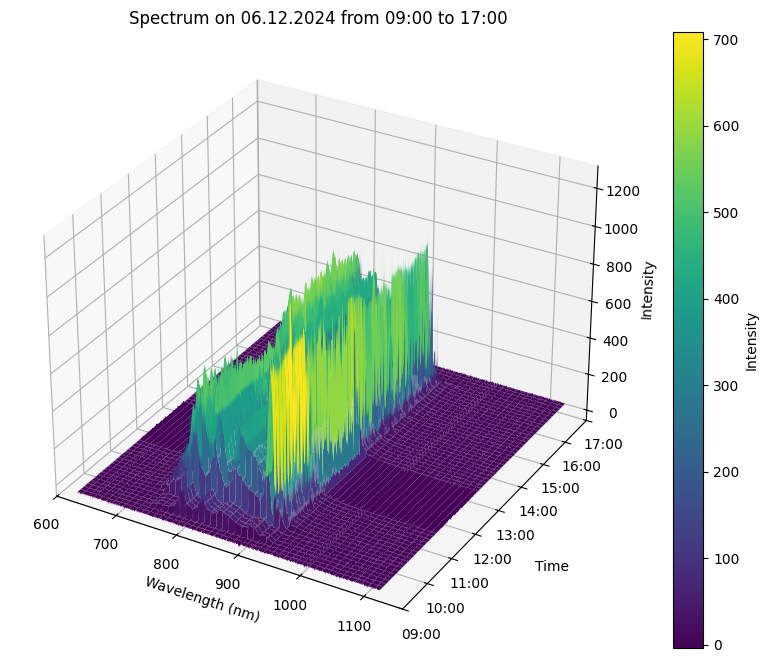

In [43]:
plot_3d_spectrogram(merged_df, "2024-12-06 9:00:00", "2024-12-06 17:00:00", wavelengths)

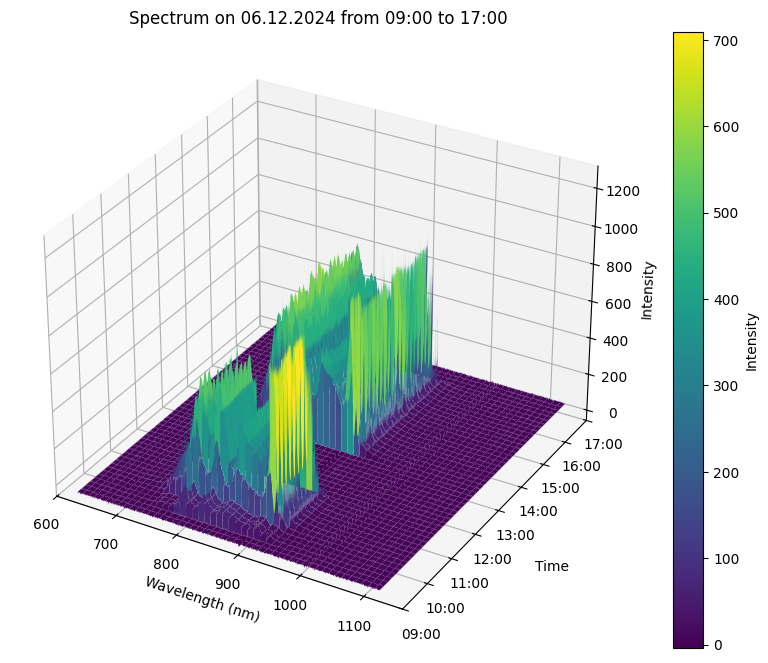

In [44]:
plot_3d_spectrogram(intensities_unfiltr, "2024-12-06 9:00:00", "2024-12-06 17:00:00", wavelengths)

In [8]:
data_path = '../data/data_merged_cleaned.csv'
data = pd.read_csv(data_path)
data['Time'] = pd.to_datetime(data['Time'])

In [10]:
data[(data['Time'].dt.date == pd.to_datetime('2024-12-06').date()) &
        (data['Time'].dt.hour <= pd.to_datetime('12:00').hour)].describe()

,Time,L1-PL3-PZM52:Setpoint,L1-PL3-PZM53:Setpoint,L1-PL3-PZM56:Setpoint,L1-PL3-PZM57:Setpoint,L1-PL3-PZM58:Setpoint,L1-PL3-PZM59:Setpoint,L1-PL4-PZM66:Setpoint,L1-PL4-PZM67:Setpoint,L1-PL4-PZM68:Setpoint,L1-PL4-PZM69:Setpoint,L1-INJ-PM70:VAL_CAL,L1-OPA3-5_2-PM98:VAL_CAL,L1-INJ-PM70:VAL_CAL_diff
count,6721,6721.000000,6721.000000,6721.000000,6721.000000,6721.000000,6721.000000,6721.000000,6721.000000,6721.000000,6721.000000,6721.000000,6721.000000,6721.000000
mean,2024-12-06 10:24:14.867823360,-0.204955,-0.479091,0.026716,-1.531586,-0.327630,-1.039429,-2.196678,-1.465744,-2.631726,1.579295,28.714723,41.877326,0.003264
min,2024-12-06 09:25:29.865771294,-0.474000,-1.094200,-0.209800,-2.493200,-1.000000,-2.000000,-3.246600,-2.986800,-3.750000,0.497100,4.590000,6.130000,-0.160000
25%,2024-12-06 09:54:51.920030720,-0.413100,-0.670400,-0.105000,-1.652300,-1.000000,-1.000000,-2.750400,-1.654600,-3.351400,1.226700,18.190000,22.680000,0.000000
50%,2024-12-06 10:24:15.217356288,-0.278200,-0.410100,0.030400,-1.454800,0.000000,-1.000000,-2.541100,-1.147400,-3.042400,1.395400,37.050000,53.190000,0.000000
75%,2024-12-06 10:53:36.251547392,-0.019100,-0.260800,0.135500,-1.349100,0.000000,-1.000000,-2.327700,-0.979900,-2.777100,1.813700,37.870000,55.340000,0.000000
max,2024-12-06 11:23:01.652202606,0.344100,-0.188300,0.397200,-0.721900,0.000000,0.000000,2.318100,-0.672100,3.750000,3.016700,38.560000,60.980000,0.240000
std,NaN,0.230803,0.242364,0.138722,0.333975,0.469384,0.195390,1.028490,0.658121,1.347537,0.547310,13.642250,19.712347,0.022006


In [12]:
parameters[(parameters['Time'].dt.date == pd.to_datetime('2024-12-09').date()) &
        (parameters['Time'].dt.hour >= pd.to_datetime('14:00').hour)].describe()

,Time,L1-PL3-PZM52:Setpoint,L1-PL3-PZM53:Setpoint,L1-PL3-PZM56:Setpoint,L1-PL3-PZM57:Setpoint,L1-PL3-PZM58:Setpoint,L1-PL3-PZM59:Setpoint,L1-PL4-PZM66:Setpoint,L1-PL4-PZM67:Setpoint,L1-PL4-PZM68:Setpoint,L1-PL4-PZM69:Setpoint,L1-INJ-PM70:VAL_CAL,L1-OPA3-5_2-PM98:VAL_CAL,L1-INJ-PM70:VAL_CAL_diff
count,94067,94067.000000,94067.000000,94067.000000,94067.000000,94067.000000,94067.000000,94067.000000,94067.000000,94067.000000,94067.000000,94067.000000,94067.000000,94067.000000
mean,2024-12-09 15:58:55.044474624,-0.647794,0.273549,-0.389579,-1.246797,-0.634845,-0.513145,-0.337483,-0.503402,-2.022743,1.031193,27.764590,47.110134,-0.007568
min,2024-12-09 14:00:00.195782185,-0.661700,0.202000,-0.604000,-1.889000,-1.000000,-1.000000,-1.731600,-0.669400,-3.750000,0.279100,-0.240000,5.640000,-1.190000
25%,2024-12-09 15:00:04.575490048,-0.651300,0.253500,-0.439500,-1.441700,-1.000000,-1.000000,-0.676800,-0.604300,-2.223100,0.885200,17.610000,46.010000,0.000000
50%,2024-12-09 16:00:44.530301952,-0.650400,0.274700,-0.384500,-1.232500,-1.000000,-1.000000,-0.015400,-0.500100,-1.929600,1.037300,36.490000,47.810000,0.000000
75%,2024-12-09 16:57:25.610151168,-0.641800,0.294500,-0.334000,-1.072000,0.000000,0.000000,0.135800,-0.409800,-1.674900,1.184400,37.190000,49.800000,0.000000
max,2024-12-09 19:58:37.521689892,-0.640000,0.318600,-0.216300,-0.326300,0.000000,0.000000,0.256900,-0.189900,-1.024500,1.363000,38.250000,57.040000,1.090000
std,NaN,0.005508,0.024916,0.072644,0.236993,0.481476,0.499830,0.631910,0.100903,0.501541,0.190525,15.201088,6.514034,0.138731
